In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/gdrive')
gitDir = "/content/gdrive/My Drive/nlp/"
import os
os.chdir(gitDir)
print(os.listdir("."))

from imgs.report_tools import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.git', 'README.md', 'data', 'presentations', '.idea', 'training', 'blobs', '.gitignore', '.ipynb_checkpoints', 'serverblobs', 'imgs', 'report.ipynb', 'compare.png']


<center><h1>Multi-Lingual Theme Prediction of Customer Reviews Using Deep Pre-Trained Embeddings</h1></center>
<p align="right">by Michael Sorg (03694850)</p>
<p align="right">Group 6</p>

# Outline

1.   Task description
2.   [Related Work](#related)


# Task Description

# 1. Related Work
<a id='related'></a>

##**!!! todo: related work set links to publication or reference cell**

For NLP related task pre-computed word embeddings like *Word2Vec* [W2V] or *Glove* [GLOVE] can improve the classification result, especially when using small datasets. However, using sentence based embeddings like the *Universal Sentence Encoder* [USE] seem to improve the performance of nlp tasks. One disadvantage of the USE is that it supports only one language and is therefore mono-lingual.

For cross-lingual sentence representations *XLING* [XLING] archives state-of-the-art performance and works addionally very well on zero-shot learning tasks.

# Package Overview
The following table lists the most important files in this repository and briefly explains what the respective file or notebook does.

- **data/Amazon Review.ipynb**
  - Downloads the Amazon Reviews Dataset
  - creating a balanced training set and save it as csv file.
  
- **data/Organic Dataset.ipynb**
  - Downloads the organic dataset
  
- **data/load_dataset.py**
  - parses the dataset csv files and create a tensorflow dataset using the Tensorflow Dataset API for efficient data loading and preprocessing


- **train/train.py** 
  - contains the model architecture and the main training loop
  - saves for each experiment the model checkpoints for each epoch and some training statistics (architecture, used datasets, training time, performance metrics for each epoch, confusion matrix etc.) in a seperate folder. This allows different experiments to be evaluated and compared later on.
  
- **train/training.ipynb**
   - high level interface to *train/train.py* for training inside google colab
   - calls the main training file with the respective parameters and plots the result inside the jupyter notebook

# Dataset

In this section I describe the used datasets as well as some interesting properties and characteristics of them.

For Training the [Amazon Reviews US](https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt) dataset was used. This Dataset contains over 130 million reviews from 1995 to 2015. For evaluation and testing the Amazon Multilingual DE dataset was used. It contains around 680.000 reviews from the german marketplace.

The following table shows the amount of reviews for the 35 different categories of the described datasets.

| Category  	|   DE	|  US 	
|:---:	|:---:	|:---:|
|  Video DVD 	| 279068  	|  85982   	
|  Music 	       | 160588  	|  4864250   	
|  Books 	       | 63784  	|  1785998   	
|  Mobile_Apps 	       | 54709  	|  4850361   
|  Digital_Video_Download 	       | 25124  	|  2634782   
|  Digital_Music_Purchase 	       | 21554  	|  2557289   
|  Toys 	       | 18602  	|  705890   
|  Digital_Ebook_Purchase 	       | 12872  	|  2402459   
|  PC 	       | 12250  	|  5069141   
|  Camera 	       | 5421  	|  1801975   
|  Wireless 	       | 4441  	|  960873   
|  Electronics 	       | 4035  	|  2642435   
|  Video 	       | 2927  	|  792114   
|  Sports 	       | 2034  	|  6908555   
|  Video Games 	       | 1706  	|  9002022   
|  Watches 	       | 1575  	|  904766   
|  Shoes 	       | 1517  	|  5331450   
|  Home 	       | 1454  	|  348658  
|  Musical Instruments 	       | 1094  	|  4880467   
|  Baby 	       | 810  	|  1103539   
|  Home Improvement 	       | 672  	|  380605   
|  Home Entertainment 	       | 605  	|  3514943   
|  Office Products 	       | 412  	|  5033377   
|  Personal_Care_Appliances 	       | 411  	|  5101694   
|  Automotive 	       | 410  	|  10319091  
|  Lawn and Garden 	       | 397  	|  4366917   
|  Luggage 	       | 247  	|  4751578   
|  Kitchen 	       | 120  	|  4057148   
|  Furniture 	       | 93  	|  2643620   
|  Health & Personal Care 	       | 37  	|  341932   
|  Software 	       | 19  	|  6221560   
|  Pet Products 	       | 2  	|  5115667  
|  Grocery 	       | 2  	|  3093870   
|  Beauty 	       | 1  	|  1688885   

As we can see in the above table both datasets are highly imbalanced. Also the distribution of reviews per category is quite different between both datasets. For example the most common category in the german reviews is *Video DVD*. However, this is one of the categories that occurs least frequently in the US reviews.



## Review length

The length of the reviews differs greatly between training and test set. This can be seen in the figure below.

review length german             |  review length us
:-------------------------:|:-------------------------:
![](imgs/histogram_de_cut.png)  |  ![](imgs/histogram_us_cut.png)


In the above histograms i randomly sampled 100.000 reviews from each dataset. We can observe the following things:
* Basically all reviews in the german dataset contain at least 160 chars which is probably some minimum required review length at the german marketplace.
* There are a lot of us reviews which are shorter than 50 characters
* Overall, the german reviews are significantly longer. This can also be seen if we look at the mean and median of the review length:

|   Dataset	|  mean 	|   median	
|:---:	|:---:	|:---	
| US  	|   345	| 169
| DE | 723 | 338

## Different languages in the test set


---



---



---


+++ TODO ++++



---



---



## balanced dataset and train-validation-test split

It has been shown that training on a unbalanced dataset can make the training process difficult and lead to bad classification results [MURP]. Additionally, due to limited computation resources and the large size of the training dataset I was not able to  all avaible data for training.
</br>In order to overcome this issues I created a balanced training dataset by sampling 10.000 random reviews from each category. Therefore the balanced dataset contains 350.000 reviews in total. For training and validating a very simple and shallow network architecture this takes around 5 hours per epoch. Due to limited ressources and time I couldn't use more data for training.
In order to evaluate the developed architecture I created a train-validation-test split. In particular I took 50.000 us reviews from the training set for validation. Additionally, I took 100.000 german reviews from the german test dataset as a second validation set. Thus, I have two validation sets - one for english reviews and one for german.

|   name	|  size 	|   description	
|:---:	|:---:	|:---	
| train  	|   300.000	| balanced, 10k reviews per category
| validation 1 | 50.000 | balanced, english
| validation 2 | 100.000 | unbalanced, german
| test | 580.000 | unbalanced, german test set

# TF-IDF based classification

*Term Frequency - Inverse Data Frequency (TF-IDF)* is a widely non deep-learning based method in the nlp area. TF-IDF estimate how important a word is within a document by counting word-frequencies.

In order to do classification we need to combine the computed tf-idf features with a classifier. Popular choices are here *Support Vector Machines (SVM) [SVM]* or a *Perceptron* [PERC]. The results of the different classifiers are stated in the table below:

|   classifier	|  validation 1 (en) 	|   validation 2 (de)	
|:---:	|:---:	|:---:	
| TF-IDF + SVM  	|   54 %         	   | 40 %
| TF-IDF + Perceptron | 45 %         | 33 %

> The above table shows the **micro f1** score on the respective test set. If the "f1 score" is reported in the following sections, then the micro-f1 score is meant.

The above classifiers were trained on english reviews only (training set). As we can see the performance drops quite a bit if we test the trained model on unseen german data. This is not very surprising, because the [Tf-idf Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) was fitted only on english words.


# Deep Learning Approach

In the previous sections the dataset and the non deep learning tf-idf baseline method were described. Now we'll discuss the results of training a neural networks based on XLING embeddings per review. The overall architecure looks like this:
![](imgs/overview.png)

XLING generates a embedding vector with a fixed length of 512 dimensions for each review. For the amazon category prediciton taks the final layer is a softmax classification with 35 classes. Now there are two open questions which we want to answer in the following sections:


1.   Which layers type (fully connected, relu, dropout) should we put between input and output layer? Which size should the fully connected layers have? 
2.   Do we train also the XLING embeddings or leave those weights untouched?



# unbalanced training

For this moment we do not train XLING embeddings and leave this weights fixed.

As stated in the previous sections the original training set is very unbalanced. What happens if we train on this unbalanced data?

For this experiment we train the simplest possible model. This is called the **baseline model** and has no hidden layer. It therefore consists only of the xling embedding layer and the final softmax classification layer.

> If not stated otherwise I will always report the *micro f1 score*. For simplicity's sake, I call this value just "f1 score".

In the following figure the loss and f1 score are shown. Both seem to look fine and the result is supringsingly good for this simplest possible architecture.

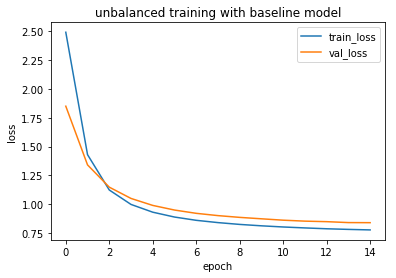

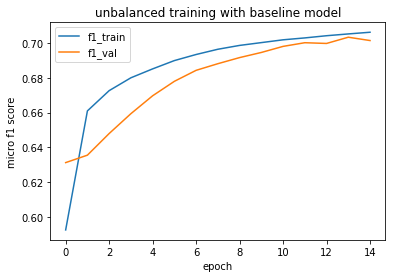

In [0]:
path = "blobs/2019-06-21_unbalanced_usde_100k_baseline/"
title = "unbalanced training with baseline model"
plotLoss(path, title)
plotF1(path, title)

But if we look at the f1 score per class we can see that there is something wrong. We can oberserve that the model never predicts about of half of the classes.  Especially classes which occur not very often (small support size) are completly ignored by the model. The model basically only learn to distinguish the most common classes. Since the micro f1 score is ill-defined for classes with no predicted samples these classes are excluded from the overall micro f1 score by sklearn. This is why the f1 score in the above plot is about 70 %.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.86      0.71      0.78     40933
           1       0.82      0.93      0.87     23591
           2       0.64      0.49      0.56      9278
           3       0.77      0.93      0.84      8137
           4       0.19      0.45      0.26      3773
           5       0.67      0.00      0.01      3219
           6       0.87      0.54      0.66      2795
           7       0.17      0.65      0.27      1872
           8       0.59      0.59      0.59      1783
           9       0.77      0.69      0.73       767
          10       0.42      0.31      0.36       670
          11       0.43      0.01      0.02       581
          12       0.00      0.00      0.00       435
          13       0.00      0.00      0.00       313
          14       0.58      0.28      0.38       242
          15       0.94      0.81      0.87       240
          16       0.93      0.82      0.87       220
          17       0.00    

<Figure size 432x288 with 0 Axes>

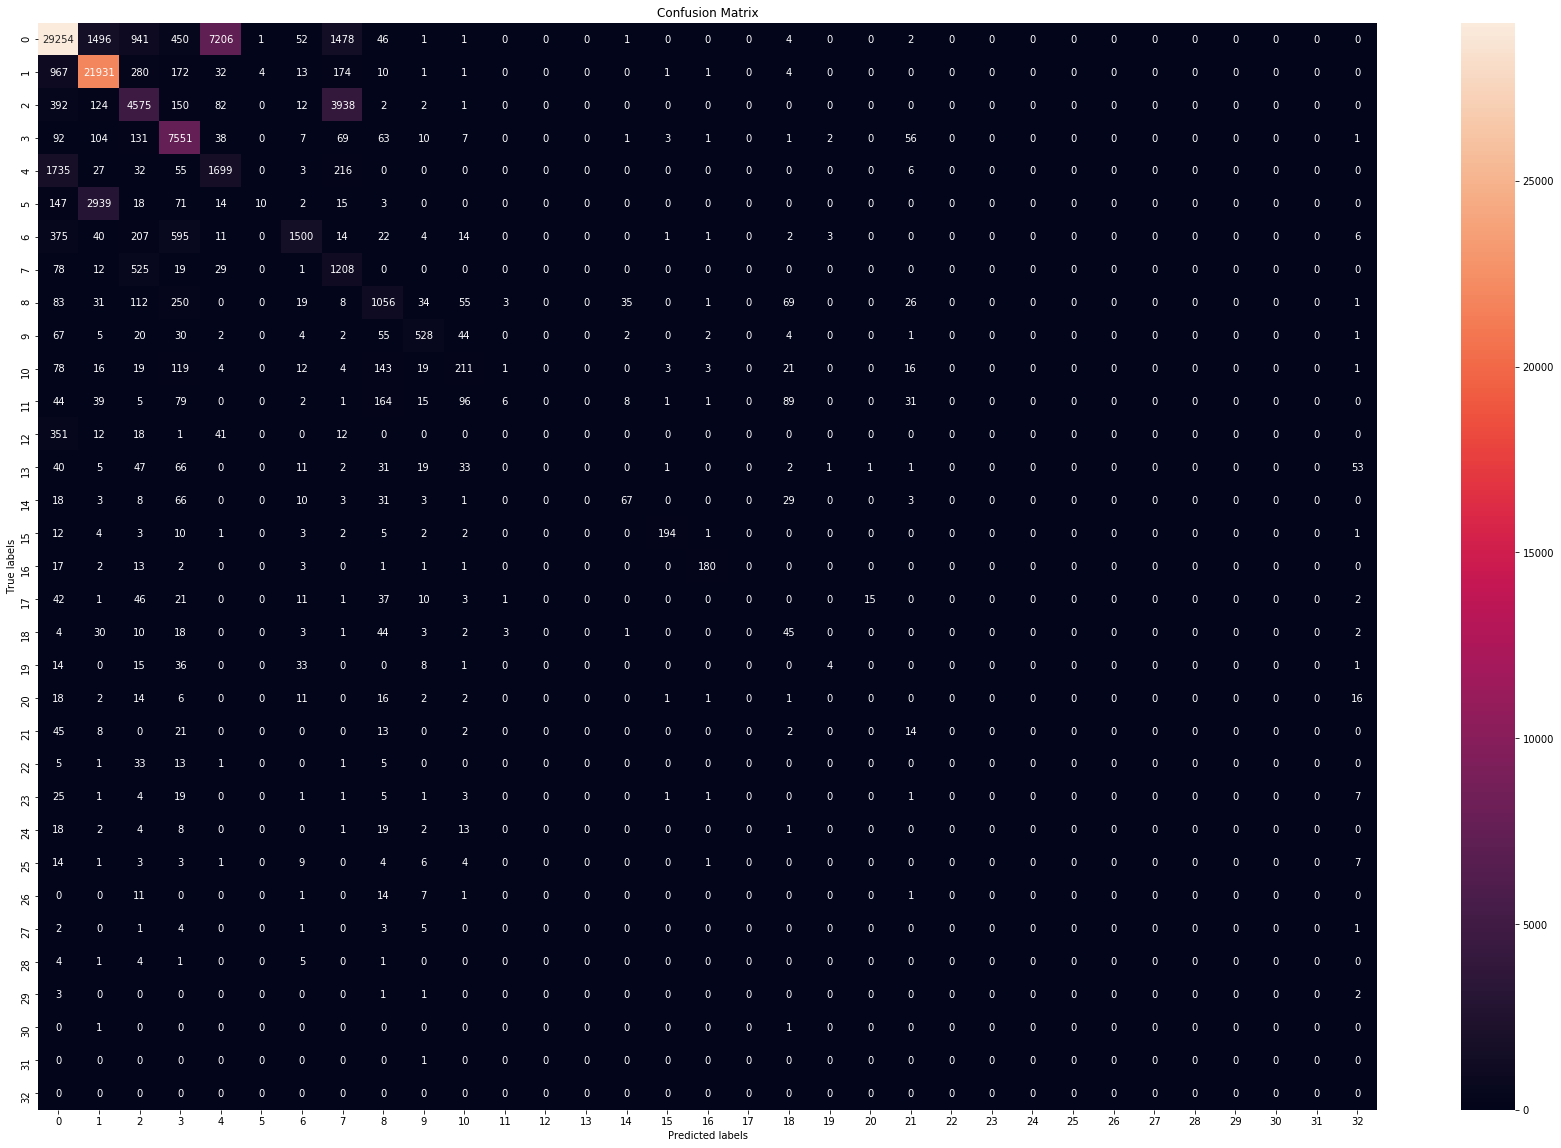

In [0]:
getClassificationReport(path, -1)
plotExperimentCM(path, -1)

The above is result is not very expecting. It is known that unbalanced datasets can lead to bad results [imbalanced datasets]. This is why we will no use the created balanced training set described before. 

# Balanced training

## overfitting (?)

path = "blobs/2019-06-21_balanced_100k_overfit_baseline/"
title = "overfitting baseline model"
plotLoss(path, title)
plotF1(path, title)

getClassificationReport(path, -1)
plotExperimentCM(path, -1)

## Baseline model

As a first baseline we train our simpelst possible model on the balanced dataset. The following things can be observed:


*   The shape of the loss and f1 score look fine. The maximum of the validation f1 score is around 51 %. Even the simpelst and shallowest model has outperformed our tf-idf baseline.
*   It is surprising that the validation loss is lower than the training loss. However, the validation f1 score is slightly below the training f1 score which was expected.
* The model does not learn to much after the 3rd epoch. The learning in the beginning is very steep. Maybe this is due to the fact that the model has very few parameters and can be improved with higher capacity. If we reduce the learning rate the curve is not as steep in the beginnign, but does not reach the same validation f1 score.



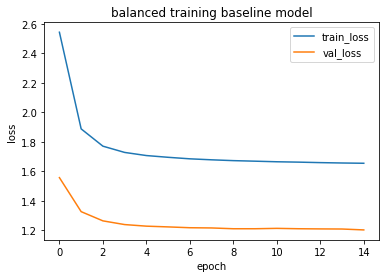

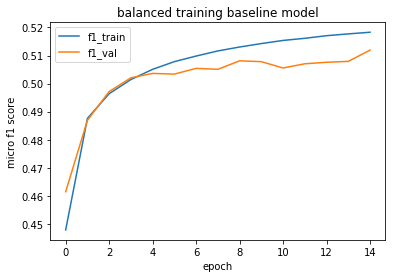

In [5]:
path = "blobs/2019-06-24_balanced_full_baseline/"
title = "balanced training baseline model"
plotLoss(path, title)
plotF1(path, title)

#getClassificationReport(path, -1)
#plotExperimentCM(path, -1)

If we look at the f1 score for each class there are two problems:


1.   The f1 score is for some classes very low or even zero. Especially classes with low support size are badly recognized. 
2.   The f1 score varies extremely between different classes.

Cause of this two problems are often training with a unbalanced dataset. However, here we use a balanced dataset. Why this problems still occur does not open up to me.




In [6]:
getClassificationReport(path, -1)

              precision    recall  f1-score   support

           0       0.91      0.35      0.51    279068
           1       0.85      0.85      0.85    160588
           2       0.73      0.33      0.45     63784
           3       0.93      0.60      0.73     54709
           4       0.19      0.43      0.27     25124
           5       0.32      0.29      0.30     21554
           6       0.74      0.64      0.68     18602
           7       0.16      0.67      0.26     12872
           8       0.60      0.50      0.54     12250
           9       0.59      0.72      0.65      5421
          10       0.39      0.33      0.36      4441
          11       0.28      0.34      0.30      4035
          12       0.02      0.69      0.03      2927
          13       0.16      0.10      0.13      2034
          14       0.07      0.49      0.13      1706
          15       0.51      0.91      0.66      1575
          16       0.68      0.87      0.76      1517
          17       0.02    

## Architecture search

To improve the result of the baseline model and find a good performing architecture a grid search was done. A selection of some tested architectures can be seen in the figure below. 

*The label [False, 150 ,r, d] means for exampel that we don't train the xling embeddings and have one hidden layer with 150 units followed by relu and dropout before the final softmax classification layer.*

The plot looks a little bit messy, but we can see the following things:
*   The blue line is the baseline model described in the previous section.
*   Except from the baseline model the f1 score fluctuates strongly (zig-zagging)
*   Overfitting happens as soon as we go deeper. Even with just 3-4 layers with a dropout layer after each fully connected layer, overfitting is happening (see for example the pink line with the architecture [False, 250, r, d, 150, r, d, 100, r, d, 50, r, d])
*  **Overall the architecure [False, 150, "r", "d"] performs best and reaches the highest f1 score of 57 %**. Training this model took around 5 hours.

For the architecture search I used the training set with a size of 300.000 samples. Does overfitting also happen if we use more training data? To test this I trained some of the deeper models on a balanced training set with around 2 million data points. Suprisingly, this didn't improve the perfromance - even worse the f1 score decreased (see Appendix.). **Using more data does not lead to better performance in my case**.
Theoretically, there is even more data in the amazon reviews dataset avaible. But due to limited computation ressources and time I was not able to use a even bigger dataset than 2 million samples.




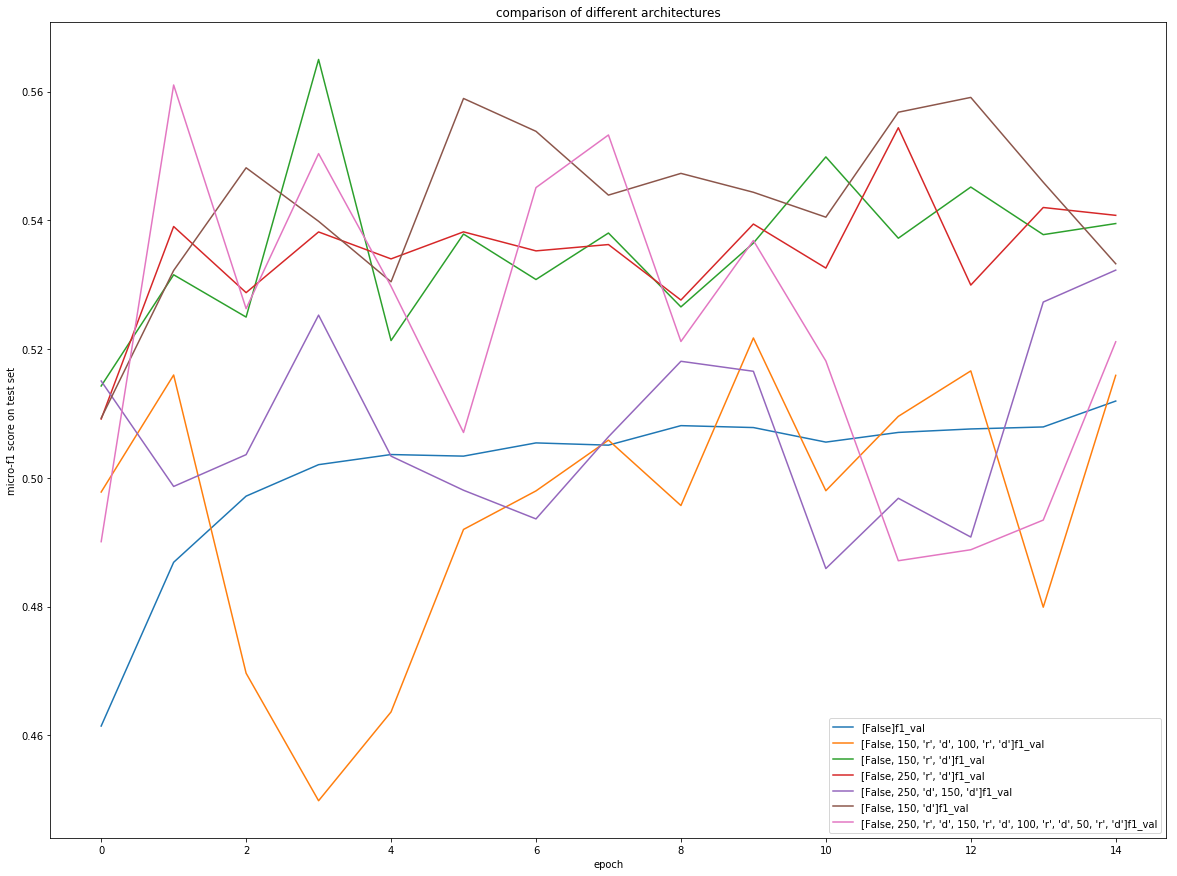

In [8]:
paths = ["blobs/2019-06-24_balanced_full_baseline/","blobs/2019-06-25_balanced_full_search1/","blobs/2019-06-25_balanced_full_search2/","blobs/2019-06-26_balanced_full_search4/",
         "blobs/2019-06-26_balanced_full_search5/","blobs/2019-06-26_balanced_full_search6/","blobs/2019-06-24_deep_balanced_300k_dropout/"]
plt.figure(figsize=(20,15))
for path in paths:
    f = glob.glob(path + "*f1_val.npy")
    x = np.load(f[0])
    plt.plot(x, label=f[0][len(path):-4])
plt.legend()
plt.title("comparison of different architectures")
plt.xlabel("epoch")
plt.ylabel("micro-f1 score on test set")
plt.savefig("compare.png")
plt.show()

## Training XLING embeddings

So far we left the XLING weights untouched and didn't train them. Now we'll include these weights also during the optimization.
For this experiment we'll use again our baseline model - meaning the simpelst possible model with the fewest possible parameters. But this time we train also the XLING weights.

The figure below shows tho different models:
1.   The *left column* shows the baseline model with trainable XLING weights **without dropout and regularization and a learning rate of 0.001**. As we can see this model is heavily overfitting. The training f1 score almost reaches 100 % after 15 epochs. Also the validation loss is increasing after 4 epochs which is a clear indicator for overfitting.
2.   The *right column* shows a model with a **additonal dropout layer and l2 regularization as well as a learning rate reduced by one tenth**. This time the loss looks better, because the validation loss does not start to increase after a few epochs. However, the generalization gap (difference between train and validation f1 score) is quite large.


We can conclude that also training the XLING embeddins does not work very well. Even with no hidden layer between XLING and the softmax classifiaction layer and with dropout, regularization and a small learning rate the model tends to overfit.

This is probably due to the fact that *training the XLING embeddings adds around 120 million additional parameters*. Ih this case I trained the model with 300.000 samples. Therefore we had way more parameter than training data. Can we overcome this issue by using more training data? To test this I trained the same models with a training set size of 2 million data points. But as described in the previous section using more data didn't help in this case either. The model were still overfitting.

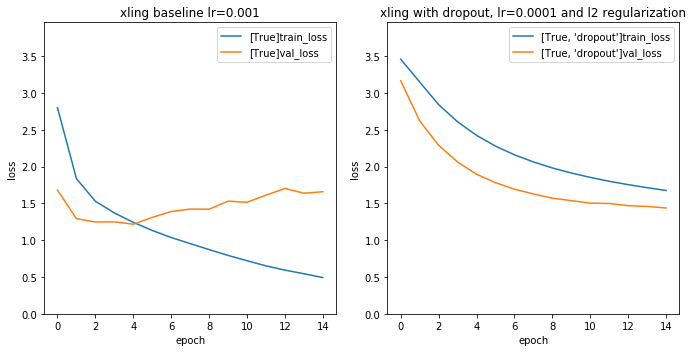

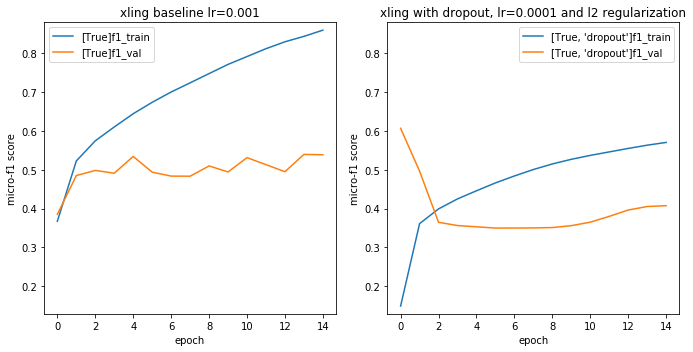

In [3]:
p1 = "blobs/2019-06-24_balanced_300k_xling_baseline/"
p2 = "blobs/2019-06-24_balanced_300k_xling_baseline_dropout_lr_l2reg/"
title1="xling baseline lr=0.001"
title2="xling with dropout, lr=0.0001 and l2 regularization"
plotExperimentLoss(p1,p2,title1, title2)
plotExperimentf1(p1,p2,title1, title2)

# Organic Dataset

For the organic dataset I also did a grid search to find a good architecture for *training a model from scratch*. But here the same problems occured like in the architecture search above. Due to the fact that the organic dataset is really small (around 4000 samples) overfitting happend here even more quickly. Basically the best architecture was the baseline model (just xling embeddings + softmax). As soon as I added additional hidden layers the performance either didn't improve or the model did overfit.

Can we increase the performance if we do fine-tuning? For this experiment I used the best perfroming model from the previous task. This model consits of XLING embeddings, a hidden layer with 150 units followed by relu, dropout and softmax classification layers. I reused this model and replaced the final softmax layer with a new one with the respective number of classes for each classifiation task (see [training/fine-tune.ipynb](training/fine-tune.ipynb) ).
Interestingly, I wasn't able to push the perfomance by the architecture search. However, by using fine-tuning on a different dataset the perfromance increased, as it can be seen in the following table:

|   Task	|  scratch model 	|   model with fine-tuning	
|:---:	|:---:	|:---:	
| relevance  	|   74 %         	   | 77 %
| entity | 51 %         | 57 %
|attribute | 44 % | 50 %
> The above table show the micro f1 score on the test set.




# Conclusion
- xling auf deutsch geht gut keine verluste
- overfitting probleme
- größeres dataset führt nicht zu bessere performacne
- xling trainings nciht trainierbar

# References
<a id='references'></a>

## Publications


| Shortcut        | Publication           | 
| :-------------:      |:------------- |
| [XLING](https://arxiv.org/abs/1810.12836)    | M. Chidambaram, Y. Yang, D. Cer, S. Yuan, Y.-H. Sung, B. Strope, and R. Kurzweil. Learning Cross-Lingual Sentence Representations via a Multi-task Dual-Encoder Model. ArXiv e-prints, October 2018.
| [USE](https://arxiv.org/abs/1803.11175)     | Daniel Cer, Yinfei Yang, Sheng-yi Kong, Nan Hua, Nicole Limtiaco, Rhomni St. John, Noah Constant, Mario Guajardo-Céspedes, Steve Yuan, Chris Tar, Yun-Hsuan Sung, Brian Strope, Ray Kurzweil. Universal Sentence Encoder. arXiv:1803.11175, 2018.    
| [W2V](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) | Mikolov, Tomas, et al. "Distributed representations of words and phrases and their compositionality." Advances in neural information processing systems. 2013.
|[ATT](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf) | Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems. 2017.
|[GLOVE](https://www.aclweb.org/anthology/D14-1162) | Pennington, Jeffrey, Richard Socher, and Christopher Manning. "Glove: Global vectors for word representation." Proceedings of the 2014 conference on empirical methods in natural language processing (EMNLP). 2014.
|[MURP](https://www.researchgate.net/profile/Yi_Murphey/publication/263756556_Neural_Learning_from_Unbalanced_Data_Special_Issue_Engineering_Intelligent_Systems_Guest_Editor_Laszlo_Monostori/links/0912f50d32991d3eed000000.pdf) | Murphey, Yi L., Hong Guo, and Lee A. Feldkamp. "Neural learning from unbalanced data." Applied Intelligence 21.2 (2004): 117-128.
| [PERC](https://link.springer.com/content/pdf/10.1023/A:1007662407062.pdf) | Freund, Yoav, and Robert E. Schapire. "Large margin classification using the perceptron algorithm." Machine learning 37.3 (1999): 277-296.
|[SVM](https://lirias.kuleuven.be/retrieve/88556) |Suykens, Johan AK, and Joos Vandewalle. "Least squares support vector machine classifiers." Neural processing letters 9.3 (1999): 293-300.

&nbsp;&nbsp;

The following publications have not been explicitly mentioned above, but are realted and contained some useful information and ideas.

| Shortcut        | Publication           | 
| :-------------:      |:------------- |
|[BERT](https://arxiv.org/pdf/1810.04805.pdf) | Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." arXiv preprint arXiv:1810.04805 (2018).


## Datasets
| Name        | Source           | 
| :-------------:      |:------------- |
|Amazon Reviews US | https://s3.amazonaws.com/amazon-reviews-pds/readme.html </br>https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt
|Amazon Multilingual DE| https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_DE_v1_00.tsv.gz
Organic Dataset | https://syncandshare.lrz.de/dl/fiNDkYy3SNfH6M62mpfPV92c/processed.zip



## Usefull internet ressources

| Topic        | Links           | 
| :-------------      |:------------- |
| sklearn tf-idf classifiaction | https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html </br> https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py </br> http://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XTG-WOgzbIU
| imbalanced datasets| https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ <br> https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
|Google Colab | todo
|google cloud instance setup DE| todo
|google cloud jupyter notebook | todo
|tensorflow dataset api | todo
|python langdetect libary| https://pypi.org/project/langdetect/


<br><br><br><br><br><br>
---
---
---
---
<center><h1>Appendix</h1></center>

- optiizer
- großese dataset
- w/o headline
- w/o filtering german reviews